## 1. Compute Summary Metrics

Parse `component_net_map.json` for each image and generate a CSV with counts and net statistics.

In [65]:
import os, glob, json, csv
from statistics import mean

# Base paths
base = os.path.join("..", "data", "processed")
out_dir = os.path.join("..", "outputs")

# Find JSONs under imgid/ or imgid/line_results/
patterns = [
    os.path.join(base, "*", "component_net_map.json"),
    os.path.join(base, "*", "line_results", "component_net_map.json")
]

rows = []
for pattern in patterns:
    for f in glob.glob(pattern):
        img = os.path.basename(os.path.dirname(f)) if "line_results" not in f else os.path.basename(os.path.dirname(os.path.dirname(f)))
        comp_net = json.load(open(f))
        counts = {}
        for e in comp_net:
            counts[e["component"][0]] = counts.get(e["component"][0], 0) + 1

        net2pins = {}
        for e in comp_net:
            net2pins.setdefault(e["net_id"], []).append(e)
        degrees = [len(v) for v in net2pins.values()] or [0]

        rows.append({
            "image": img,
            "resistors": counts.get("R", 0),
            "caps": counts.get("C", 0),
            "transistors": sum(v for k, v in counts.items() if k.startswith("M")),
            "nets": len(net2pins),
            "avg_pins_per_net": round(mean(degrees), 2)
        })

if rows:
    os.makedirs(out_dir, exist_ok=True)
    csv_path = os.path.join(out_dir, "summary_metrics.csv")
    with open(csv_path, "w", newline="") as csvf:
        writer = csv.DictWriter(csvf, fieldnames=rows[0].keys())
        writer.writeheader()
        writer.writerows(rows)
    print(f"✅ Generated {csv_path} with {len(rows)} entries.")
else:
    print("⚠️ No JSON files found under patterns:", patterns)


✅ Generated ../outputs/summary_metrics.csv with 330 entries.


## 2. Connectivity Graph Visualization

Build a NetworkX graph for a selected net and plot its subgraph.

In [66]:
import os, glob, json
import networkx as nx
import matplotlib.pyplot as plt

# Paths relative to notebooks/
data_base   = os.path.join("..", "data", "processed")
outputs_root = os.path.join("..", "outputs")

# Find all component_net_map.json files
pattern     = os.path.join(data_base, "*", "component_net_map.json")
pattern_lr  = os.path.join(data_base, "*", "line_results", "component_net_map.json")
all_json    = glob.glob(pattern) + glob.glob(pattern_lr)

for cnm_path in all_json:
    # Determine imgid
    parts = cnm_path.split(os.sep)
    imgid = parts[parts.index("processed")+1]

    # Load component-net mapping
    comp_net = json.load(open(cnm_path))

    # Build bipartite graph
    G = nx.Graph()
    for e in comp_net:
        G.add_edge(e["component"], f"NET{e['net_id']}")

    # Select the net with the most connections
    net_degrees = {n: d for n, d in G.degree() if n.startswith("NET")}
    if not net_degrees:
        continue
    top_net = max(net_degrees, key=net_degrees.get)

    # Extract ego-graph
    sub = nx.ego_graph(G, top_net, radius=1)

    # Prepare output directory
    out_dir = os.path.join(outputs_root, imgid)
    os.makedirs(out_dir, exist_ok=True)

    # Plot and save
    plt.figure(figsize=(5,5))
    nx.draw(sub, with_labels=True, node_size=300, font_size=6)
    plt.title(f"{imgid} – {top_net}")
    out_file = os.path.join(out_dir, f"{imgid}_{top_net.lower()}_subgraph.png")
    plt.savefig(out_file, dpi=150, bbox_inches='tight')
    plt.close()
  


## 2.2 Display 5 Random Subgraphs

This cell finds all `*_subgraph.png` files, picks 5 at random, and displays them inline.


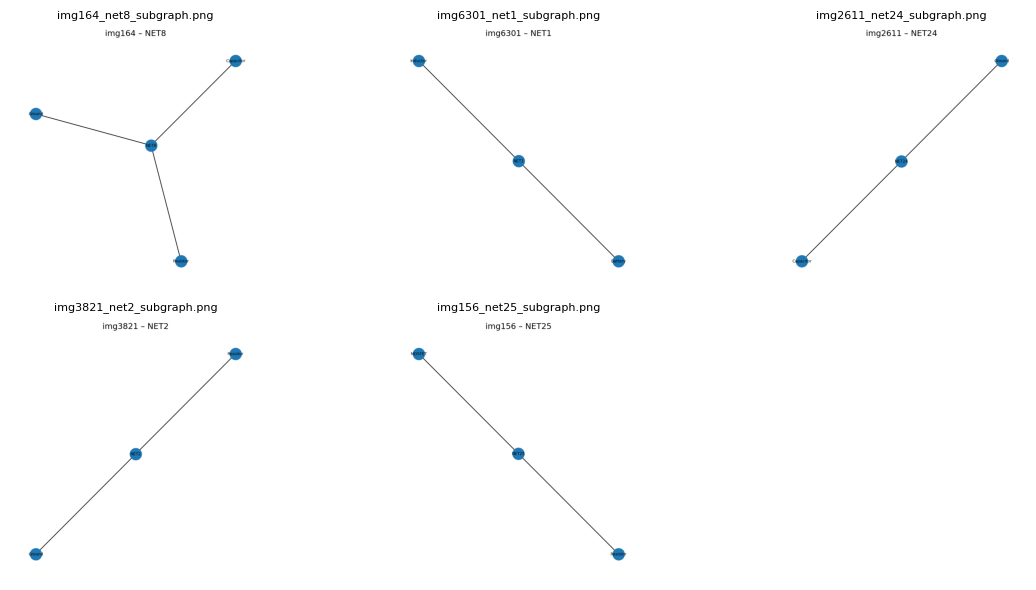

In [81]:
import glob, random
from PIL import Image
import matplotlib.pyplot as plt

# Gather all subgraph files under outputs/
subgraphs = glob.glob(os.path.join("..", "outputs", "*", "*_subgraph.png"))
if not subgraphs:
    print("No subgraph images found—run the previous cell first.")
else:
    sample = random.sample(subgraphs, min(5, len(subgraphs)))
    cols = 3
    rows = (len(sample) + cols - 1) // cols
    plt.figure(figsize=(cols*4, rows*3))

    for i, path in enumerate(sample, 1):
        img = Image.open(path)
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.set_title(os.path.basename(path), fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [68]:
import json
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

# 1) Define base paths (from notebooks/)
PROJECT_ROOT = Path("..")
PROCESSED   = PROJECT_ROOT / "data" / "processed"
OUTPUTS     = PROJECT_ROOT / "outputs"
OUTPUTS.mkdir(exist_ok=True)

# 2) Styling map
TYPE_COLORS = {
    "R": "#1f77b4",  # resistors
    "C": "#ff7f0e",  # capacitors
    "M": "#2ca02c",  # MOSFETs/transistors
    "U": "#d62728",  # ICs/subblocks
    "default": "#9467bd"
}

# 3) Helper to find component_net_map.json under each folder
def locate_comp_map(folder: Path) -> Path:
    # looks in folder/ or folder/line_results/
    for candidate in (folder / "component_net_map.json",
                      folder / "line_results" / "component_net_map.json"):
        if candidate.exists():
            return candidate
    return None

# 4) Build graph
def build_graph(comp_map_path: Path) -> nx.Graph:
    data = json.loads(comp_map_path.read_text())
    net2comps = {}
    for e in data:
        net2comps.setdefault(e["net_id"], set()).add(e["component"])
    G = nx.Graph()
    for comp in {e["component"] for e in data}:
        color = TYPE_COLORS.get(comp[0], TYPE_COLORS["default"])
        G.add_node(comp, color=color)
    for net, comps in net2comps.items():
        comps = list(comps)
        for i in range(len(comps)):
            for j in range(i+1, len(comps)):
                u, v = comps[i], comps[j]
                if G.has_edge(u, v):
                    G[u][v]["nets"].append(net)
                else:
                    G.add_edge(u, v, nets=[net])
    return G

# 5) Draw & save
def draw_and_save(G: nx.Graph, imgid: str, out_path: Path):
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=0)
    nx.draw_networkx_nodes(G, pos,
        node_color=[G.nodes[n]["color"] for n in G.nodes()],
        node_size=600
    )
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, width=1.5)
    edge_labels = {
        (u,v): ",".join(map(str,d["nets"]))
        for u,v,d in G.edges(data=True)
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title(f"Circuit Graph: {imgid}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

# 6) Main loop over data/processed/<imgid>/
for folder in sorted(PROCESSED.iterdir()):
    if not folder.is_dir(): continue
    imgid = folder.name
    comp_map = locate_comp_map(folder)
    if comp_map is None:
        print(f"⚠️ Skipping {imgid}: component_net_map.json not found")
        continue
    
    G = build_graph(comp_map)
    out_sub = OUTPUTS / imgid
    out_sub.mkdir(exist_ok=True)
    out_file = out_sub / f"{imgid}_circuit_graph.png"
    draw_and_save(G, imgid, out_file)
  


## 3.2 Display One Random Full Collage

This cell picks **one** random `full_collage.png` from `../outputs/*/` and displays it inline.


In [69]:
import os, glob
from PIL import Image

# Base dirs
data_base    = os.path.join("..", "data", "processed")
outputs_root = os.path.join("..", "outputs")
os.makedirs(outputs_root, exist_ok=True)

# The six files we want, in the exact order they’ll appear:
filenames = [
    "clustered_nodes.png",
    "mapping.png",
    "nets_colored.png",
    "cleaned.png",
    "detected_components.png",
    "subblock_detected.png"
]

for folder in glob.glob(os.path.join(data_base, "*")):
    imgid = os.path.basename(folder)
    images = []
    # try both locations for each file
    for name in filenames:
        # first look under line_results/, then at top level
        paths = [
            os.path.join(folder, "line_results", name),
            os.path.join(folder, name)
        ]
        found = next((p for p in paths if os.path.exists(p)), None)
        if found:
            images.append(Image.open(found))
        else:
            # placeholder blank if missing
            w,h = Image.open(os.path.join(folder, "cleaned.png")).size
            images.append(Image.new("RGB", (w,h), "white"))
    # build 2×3 canvas
    w,h = images[0].size
    canvas = Image.new("RGB", (w*3, h*2), "white")
    for i, img in enumerate(images):
        x = (i % 3) * w
        y = (i // 3) * h
        canvas.paste(img, (x,y))
    # save
    out_dir = os.path.join(outputs_root, imgid)
    os.makedirs(out_dir, exist_ok=True)
    canvas.save(os.path.join(out_dir, "full_collage.png"))
    


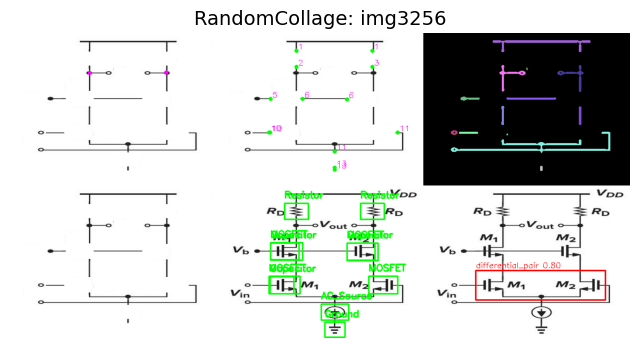

In [70]:
import os
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt

# Pattern for annotated collages
pattern = os.path.join("..", "outputs", "*", "full_collage.png")
files = glob.glob(pattern)

if not files:
    print("⚠️ No annotated collages found. Please run the annotation cell first.")
else:
    choice = random.choice(files)
    img = Image.open(choice)

    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.title(f"RandomCollage: {os.path.basename(os.path.dirname(choice))}", fontsize=14)
    plt.axis('off')
    plt.show()


## 5. Generate SPICE Stub for All Images

This cell loops over every `netlist.txt` under `../data/processed/<imgid>/`, creates a SPICE skeleton `.cir` file, and saves it to `../outputs/<imgid>/full_netlist.cir`.


In [71]:
import os, glob

# Base paths (from notebooks/)
data_base    = os.path.join("..", "data", "processed")
outputs_root = os.path.join("..", "outputs")
os.makedirs(outputs_root, exist_ok=True)

# For each image folder
for folder in glob.glob(os.path.join(data_base, "*")):
    imgid = os.path.basename(folder)
    netlist_path = os.path.join(folder, "netlist.txt")
    if not os.path.exists(netlist_path):
        # also check in line_results/
        netlist_path = os.path.join(folder, "line_results", "netlist.txt")
        if not os.path.exists(netlist_path):
            continue

    # Prepare output folder
    out_dir = os.path.join(outputs_root, imgid)
    os.makedirs(out_dir, exist_ok=True)
    cir_path = os.path.join(out_dir, "full_netlist.cir")

    # Write SPICE stub
    with open(cir_path, "w") as fout:
        fout.write("* Auto-generated SPICE netlist\n")
        fout.write(".include technology_models.lib\n")
        for line in open(netlist_path):
            net, comps = line.strip().split(":")
            comps = [c.strip() for c in comps.split(",") if c.strip()]
            for c in comps:
                name, pin = c.split(".")
                fout.write(f"X{name}_{pin} {net} dummy_subckt\n")
        fout.write(".end\n")

 


## 5.1 Display One Random SPICE Stub

This cell picks one random `full_netlist.cir` from `../outputs/<imgid>/` and prints its contents inline.


In [72]:
import os
import glob
import random

# Pattern to find all generated SPICE stub files
pattern = os.path.join("..", "outputs", "*", "full_netlist.cir")
stub_files = glob.glob(pattern)

if not stub_files:
    print("⚠️ No SPICE stub files found. Run the SPICE stub generation cell first.")
else:
    # Choose one at random
    choice = random.choice(stub_files)
    print(f"### Showing contents of: {choice}\n")
    # Read and print its contents
    with open(choice) as f:
        print(f.read())


### Showing contents of: ../outputs/img2750/full_netlist.cir

* Auto-generated SPICE netlist
.include technology_models.lib
XMOSFET_pin2 NET3 dummy_subckt
XCapacitor_pin3 NET3 dummy_subckt
XCapacitor_pin3 NET3 dummy_subckt
XCapacitor_pin3 NET3 dummy_subckt
XCapacitor_pin0 NET5 dummy_subckt
XMOSFET_pin2 NET10 dummy_subckt
XMOSFET_pin3 NET11 dummy_subckt
XCapacitor_pin1 NET14 dummy_subckt
XGround_pin0 NET14 dummy_subckt
XCurrent_Source_pin0 NET15 dummy_subckt
XCurrent_Source_pin1 NET17 dummy_subckt
XGround_pin0 NET17 dummy_subckt
.end



## 5. Static HTML Gallery

Generate a simple `gallery.html` to browse outputs.

In [73]:
import os, glob, shutil

# Source roots
processed_base = os.path.join("..", "data", "processed")
raw_base       = os.path.join("..", "data", "raw")

# Destination root
outputs_root = os.path.join("..", "outputs")
os.makedirs(outputs_root, exist_ok=True)

# Files to mirror from processed
to_copy = [
    ("line_results", "clustered_nodes.png"),
    ("line_results", "mapping.png"),
    ("line_results", "nets_coloured.png"),
    ("",              "cleaned.png"),
    ("",              "detected_components.png"),
    ("",              "subblock_detected.png"),
    ("",              "full_collage.png"),
    ("",              "full_collage_annotated.png"),
    ("",              "full_netlist.cir"),
    ("",              "component_net_map.json")
]

# Iterate over each schematic folder
for proc_folder in glob.glob(os.path.join(processed_base, "*")):
    imgid = os.path.basename(proc_folder)
    dest_dir = os.path.join(outputs_root, imgid)
    os.makedirs(dest_dir, exist_ok=True)
    
    # 1) Copy processed artifacts
    for subdir, fname in to_copy:
        src_path = (
            os.path.join(proc_folder, subdir, fname)
            if subdir else
            os.path.join(proc_folder, fname)
        )
        if os.path.exists(src_path):
            shutil.copy(src_path, os.path.join(dest_dir, fname))
    
    # 2) Copy raw image (png, jpg, or jpeg) as raw.png
    for ext in (".png", ".jpg", ".jpeg"):
        raw_src = os.path.join(raw_base, imgid + ext)
        if os.path.exists(raw_src):
            shutil.copy(raw_src, os.path.join(dest_dir, "raw.png"))
            break




In [74]:
from jinja2 import Template
import os

# Root of your outputs folder
ROOT = os.path.abspath(os.path.join("..", "outputs"))

detail_tpl = Template("""<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>{{ imgid }} – Details</title>
  <style>
    body { font-family: 'Segoe UI', sans-serif; margin:0; display:flex;flex-direction:column;min-height:100vh }
    header, footer { background: #004080; color: white; padding: 1rem; text-align:center }
    main { flex:1; padding:2rem }
    .back { color:#004080; text-decoration:none; font-weight:bold; }
    .main-collage img, .artifact img { max-width:100%; border:2px solid #ddd; border-radius:4px; }
    .artifact { margin:2rem 0 }
    .artifact h3 { margin-bottom:0.5rem; color:#333 }
    a.art-link { color:#0066cc; text-decoration:none }
    a.art-link:hover { text-decoration:underline }
    footer p { margin:0.2rem; font-size:0.9rem }
    footer a { color:#ffc; text-decoration:underline }
  </style>
</head>
<body>
  <header><h1>{{ imgid }}</h1></header>
  <main>
    <p><a class="back" href="../gallery.html">&larr; Back to Gallery</a></p>

    {% if 'full_collage.png' in files %}
      <div class="main-collage">
        <h2>Full 2×3 Collage</h2>
        <img src="full_collage.png" alt="Full collage">
      </div>
    {% endif %}

    {% for name, label in artifacts %}
      <div class="artifact">
        <h3>{{ label }}</h3>
        {% if name.endswith('.cir') or name.endswith('.json') or name.endswith('.txt') %}
          <a class="art-link" href="{{ name }}">{{ name }}</a>
        {% else %}
          <img src="{{ name }}" alt="{{ label }}">
        {% endif %}
      </div>
    {% endfor %}
  </main>
  <footer>
    <p><strong>Fatih Baştürk</strong> | B.Sc. Senior, Electrical & Electronics Engineering</p>
    <p>Boğaziçi University | <a href="mailto:fatih.basturk@std.bogazici.edu.tr">fatih.basturk@std.bogazici.edu.tr</a></p>
  </footer>
</body>
</html>
""")

for imgid in sorted(os.listdir(ROOT)):
    folder = os.path.join(ROOT, imgid)
    if not os.path.isdir(folder): continue

    files = sorted(os.listdir(folder))
    files_no_html = [f for f in files if not f.endswith('.html')]

    label_map = {
        "raw.png": "Raw Schematic",
        "pipeline_collage.png": "Pipeline 2×3 Collage",
        "full_collage.png": "Full 2×3 Collage",
        "full_collage_annotated.png": "Annotated Full Collage",
        "full_netlist.txt": "Netlist (TXT)",
        "full_netlist.cir": "SPICE Stub (.cir)",
        "component_net_map.json": "Component→Net JSON"
    }
    artifacts = [(f, label_map.get(f, f))
                 for f in files_no_html if f != "full_collage.png"]

    html = detail_tpl.render(imgid=imgid, files=files_no_html, artifacts=artifacts)
    with open(os.path.join(folder, f"{imgid}.html"), "w") as fh:
        fh.write(html)

print("✅ Detail pages regenerated.")


✅ Detail pages regenerated.


In [75]:
from jinja2 import Template
import os

# Root of your outputs folder
ROOT = os.path.abspath(os.path.join("..", "outputs"))

gallery_tpl = Template("""<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>Schematic Analysis Gallery</title>
  <style>
    body { font-family: 'Segoe UI', sans-serif; margin:0; display:flex;flex-direction:column;min-height:100vh; background:#f5f5f5 }
    header, footer { background: #004080; color: white; padding: 1rem; text-align:center }
    main { flex:1; padding:2rem }
    .grid { display: grid; grid-template-columns: repeat(auto-fill, minmax(200px,1fr)); gap:1.5rem }
    .card { background:white; border-radius:8px; overflow:hidden; text-align:center; box-shadow:0 2px 6px rgba(0,0,0,0.1); text-decoration:none; color:#333 }
    .card img { width:100%; height:150px; object-fit:cover }
    .card h2 { margin:0.5rem 0 1rem; font-size:1.1rem; }
    footer p { margin:0.2rem; font-size:0.9rem }
    footer a { color:#ffc; text-decoration:underline }
  </style>
</head>
<body>
  <header><h1>Schematic Analysis Gallery</h1></header>
  <main>
    <div class="grid">
      {% for imgid in imgids %}
        <a class="card" href="{{ imgid }}/{{ imgid }}.html">
          {% set thumb = imgid + '/raw.png' %}
          {% if thumb|file_exists %}
            <img src="{{ thumb }}" alt="{{ imgid }} raw schematic">
          {% else %}
            <div style="height:150px; display:flex;align-items:center;justify-content:center;color:#999">
              No preview
            </div>
          {% endif %}
          <h2>{{ imgid }}</h2>
        </a>
      {% endfor %}
    </div>
  </main>
  <footer>
    <p><strong>Fatih Baştürk</strong> | B.Sc. Senior, Electrical & Electronics Engineering</p>
    <p>Boğaziçi University | <a href="mailto:fatih.basturk@std.bogazici.edu.tr">fatih.basturk@std.bogazici.edu.tr</a></p>
  </footer>
</body>
</html>
""")

# Helper filter to check file existence
def file_exists(path):
    return os.path.exists(os.path.join(ROOT, path))
gallery_tpl.environment.filters['file_exists'] = file_exists

# Gather all image IDs (subdirectories in outputs)
imgids = sorted([
    name for name in os.listdir(ROOT)
    if os.path.isdir(os.path.join(ROOT, name))
])

# Render and write gallery.html
html = gallery_tpl.render(imgids=imgids)
with open(os.path.join(ROOT, "gallery.html"), "w") as f:
    f.write(html)

print("✅ Top-level gallery regenerated at outputs/gallery.html")


✅ Top-level gallery regenerated at outputs/gallery.html
